In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

%load_ext autoreload
%autoreload 2
sns.set(style="darkgrid")

In [2]:
conditions = {
    0: "RandomTutor",
    1: "StrategyTutor"
}

In [3]:
# path = os.getcwd() + "/dummy_tutor/prolific_export_611e1af8e9640d2fdf6f0ac4 (1).csv"
# def prolific_completion_time(path: str):
#     df = pd.read_csv(path)
#     times = df.loc[df["status"]=="APPROVED", ["time_taken"]].mean() / 60
#     print("Average completion time:", times)

# prolific_completion_time(path)

In [4]:
survey = pd.read_csv(os.getcwd() + "/dummy_tutor/survey.csv")

print("Average age", survey["What is your age?"].mean())
print(f"Age range from {survey['What is your age?'].min()} to {survey['What is your age?'].max()}")

male = ["male", "malei", "man", "m"]
female = ["female", "f", "woman", "w"]
genders = [x.strip().lower() for x in  survey["What gender do you identify with?"].tolist()]
print("Male:", len([x for x in genders if x in male]))
print("Female:", len([x for x in genders if x in female]))
print("Other:", [x for x in genders if x not in male+female])

Average age 25.06
Age range from 18 to 48
Male: 47
Female: 53
Other: []


In [5]:
df_after_exclusion = pd.read_csv(os.getcwd() + "/dummy_tutor/main_excluded.csv", converters={'AgreementDetails': eval})
df_after_exclusion["NamedCondition"] = df_after_exclusion["Condition"].apply(lambda x: conditions[x])

In [6]:
print("Total participants", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["NamedCondition", "Participant"]).count()["TrialId"].reset_index().groupby("NamedCondition").count()

Total participants 78


,Participant,TrialId
NamedCondition,,
RandomTutor,36,36
StrategyTutor,42,42


In [7]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
counts = df_after_exclusion.groupby("Participant").median().groupby("Condition").sum()["GoalStrategy"].astype(int).tolist()
nobs = df_after_exclusion.groupby("Participant").median().groupby("Condition").count()["GoalStrategy"].tolist()

count = np.array([counts[1], counts[0]])
nob = np.array([nobs[1], nobs[0]])
stat, pval = proportions_ztest(count, nob)

print(f"Z-test between condition {conditions[0]} and {conditions[1]}: z={np.round(stat, 3)}, p={np.round(pval, 5)}")

Z-test between condition RandomTutor and StrategyTutor: z=3.324, p=0.00089


<AxesSubplot:xlabel='ExpectedScore', ylabel='Count'>

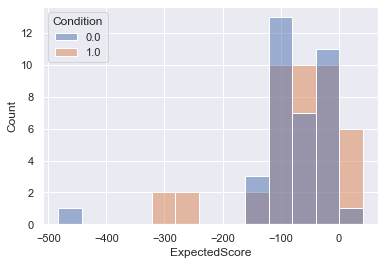

In [8]:
sns.histplot(data=df_after_exclusion.groupby("Participant").mean(), x="ExpectedScore", hue="Condition")

In [9]:
# Check outlier impact (not reported)
participant_df = df_after_exclusion.groupby("Participant").mean()
excl = list(participant_df[participant_df["ExpectedScore"]<-200].index)

df_after_exclusion[~df_after_exclusion["Participant"].isin(excl)].groupby("Condition").agg(["mean", "median", "std"])[["ExpectedScore"]]

ExpectedScore                  
                   mean median        std
Condition                                
0            -68.257143  -90.0  82.054910
1            -46.789474  -60.0  76.809445

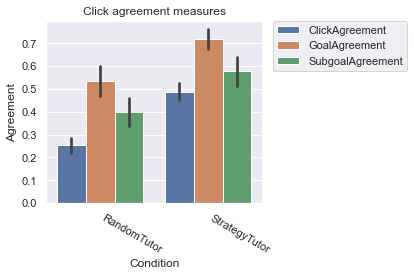

In [10]:
# Click Agreement
dfs = []
for category in ("ClickAgreement", "GoalAgreement", "SubgoalAgreement"):
    partial_df = df_after_exclusion[["Condition", category]].copy()
    partial_df.columns = ["Condition", "Agreement"]
    partial_df["Measurement"] = category
    dfs.append(partial_df)
agreement_df = pd.concat(dfs)
ax = sns.barplot(data=agreement_df[~agreement_df["Agreement"].isna()], x="Condition", y="Agreement", hue="Measurement")
_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')
_ = ax.set_title("Click agreement measures")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("./dummy_tutor/img/click_agreement.png")

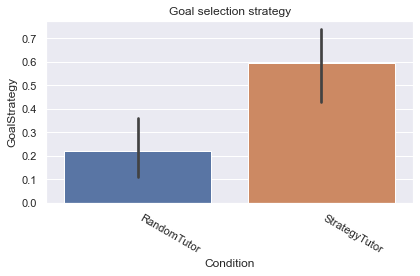

In [11]:
ax = sns.barplot(data=df_after_exclusion.groupby("Participant").median(), x="Condition", y="GoalStrategy")

_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')

plt.title("Goal selection strategy")
plt.tight_layout()
plt.savefig("./dummy_tutor/img/goal_strategy.png")

In [12]:
df_after_exclusion.groupby("Participant").median().groupby("Condition").agg(["mean"])["GoalStrategy"]

,mean
Condition,
0.0,0.222222
1.0,0.595238


In [13]:
click_agreement_per_participant = df_after_exclusion.groupby("Participant").mean()[["Condition", "ClickAgreement"]]
click_agreement_per_participant["LearnedStrategy"] = click_agreement_per_participant["ClickAgreement"] > 0.5
click_agreement_per_participant.groupby("Condition").mean()["LearnedStrategy"]

Condition
0.0    0.027778
1.0    0.476190
Name: LearnedStrategy, dtype: float64

<AxesSubplot:xlabel='Condition', ylabel='ExpectedScore'>

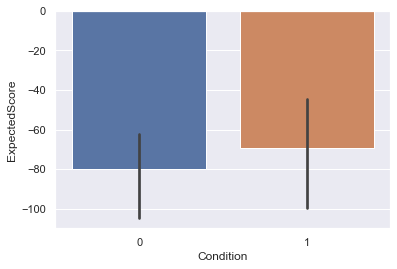

In [14]:
sns.barplot(data=df_after_exclusion, x="Condition", y="ExpectedScore")

In [15]:
from scipy.stats import iqr
df_after_exclusion.groupby("NamedCondition")["ExpectedScore"].agg(["median", iqr])

,median,iqr
NamedCondition,,
RandomTutor,-90.0,121.25
StrategyTutor,-57.5,145.00


In [16]:
df_after_exclusion.groupby("Condition").agg(["mean", "std"])[["ExpectedScore", "ClickAgreement","GoalAgreement", "SubgoalAgreement", "TermAgreement","GoalTermAgreement","SubgoalTermAgreement"]].round(4)

ExpectedScore           ClickAgreement         GoalAgreement  \
                   mean       std           mean     std          mean   
Condition                                                                
0              -79.7778  148.4894         0.2528  0.2303        0.5355   
1              -69.1429  211.6041         0.4871  0.2825        0.7161   

                  SubgoalAgreement         TermAgreement          \
              std             mean     std          mean     std   
Condition                                                          
0          0.3892           0.3994  0.3829        0.6603  0.2282   
1          0.3171           0.5778  0.4043        0.7297  0.1944   

          GoalTermAgreement         SubgoalTermAgreement          
                       mean     std                 mean     std  
Condition                                                         
0                    0.6537  0.3184               0.6700  0.3064  
1                    0.7192  0.3070               0.6751  0.3576

<AxesSubplot:xlabel='Condition', ylabel='ExpectedScore'>

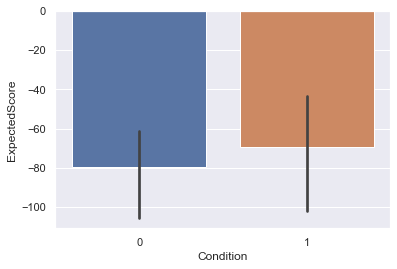

In [17]:
sns.barplot(x="Condition",y="ExpectedScore",data=df_after_exclusion)

In [18]:
df_after_exclusion.groupby("Condition").std()["ExpectedScore"]

Condition
0    148.489435
1    211.604100
Name: ExpectedScore, dtype: float64